In [ ]:
# %% [markdown]
# ## 6.3 · Ajuste de parámetros de las métricas (precisión vs. coste)

# %%
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

# Métricas (asumo mismos imports que en 6.2)
from ReduMetrics.metrics.ulse import ulse_score_sklearn
from ReduMetrics.metrics.rta import rta_score
from ReduMetrics.metrics.spearman import spearman_correlation
from ReduMetrics.metrics.k_ncp import kncp_score
from ReduMetrics.metrics.cdc import cdc_score

original = pd.read_csv('../data/fashion_mnist_flattened.csv', header=None)
pca = pd.read_csv('../data/fashion_mnist_pca.csv')
tsne = pd.read_csv('../data/fashion_mnist_tsne.csv')
umap = pd.read_csv('../data/fashion_mnist_umap.csv')


labels = original[original.columns[-1]]
features = original.iloc[:, :-1]

# Carpeta de salidas
FIGDIR = "figuras"
RESDIR = "resultados"
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(RESDIR, exist_ok=True)

# ------------------ Decisiones de diseño (justificables en la memoria) ------------------
SEED = 12345
rng = np.random.default_rng(SEED)

# Usamos como embebido de referencia UMAP 2D: buena preservación local y muy habitual en práctica.
EMBED = "UMAP"   # ("UMAP" | "t-SNE" | "PCA") -> puedes cambiarlo si quieres comparar otro

# Submuestreo estratificado para cada repetición: tamaño moderado para estabilizar y ser rápidos.
M_SUB = 6000     # en 6.2 usamos 10k; aquí bajamos a 6k para poder repetir muchas veces

# Repeticiones por métrica (remuestreo estratificado + semilla interna cuando aplique)
B_ULSE = 15
B_RTA  = 20
B_SPEAR= 20
B_KNCP = 20
B_CDC  = 20

# Umbral de estabilidad: anchura del IC95 ≤ EPS se considera "suficiente"
EPS = 0.01

# Grids de parámetros
GRID_ULSE_K = [5, 10, 20, 50, 100]                         # cap en 100 para no perder "localidad"
GRID_RTA_T  = [2000, 5000, 10000, 20000, 50000]
GRID_SPEAR_P= [2000, 5000, 10000, 20000, 50000]
# Para k-NCP depende del nº de clases; con C=10 probamos k=3 y k=5
GRID_KNCP_K = ["auto", 3, 5]  # con C=10, 3≈regla dinámica; añade 2 o 8 si quieres explorar más

# Sensibilidad opcional con ruido leve en el embebido (como A3). Lo dejamos apagado por defecto.
DO_SENSITIVITY = False
SIGMA_NOISE = 0.05

# ------------------ Helpers ------------------
def standardize_columns(X: np.ndarray) -> np.ndarray:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    return (X - mu) / sd

def stratified_subsample(X: np.ndarray, y: np.ndarray, size: int, seed: int):
    size = min(size, len(y))
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=size, random_state=seed)
    (idx_sub, _), = splitter.split(X, y)
    idx_sub = np.sort(idx_sub)
    return X[idx_sub], y[idx_sub], idx_sub

def line_with_band(x, y_mean, y_std, title, xlabel, ylabel, file_out=None, ylim=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x, y_mean, marker="o")
    ax.fill_between(x, (y_mean - y_std), (y_mean + y_std), alpha=0.2)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if file_out is not None:
        fig.savefig(file_out, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def dual_panel_metric_time(x, m_mean, m_std, t_mean, t_std,
                           title, xlabel, ylabel_m, ylabel_t,
                           file_out=None):
    import numpy as np
    import matplotlib.pyplot as plt

    # Convertimos a array de objetos para poder inspeccionar tipos
    x_arr = np.array(list(x), dtype=object)

    # ¿Todos numéricos? -> usamos valores tal cual. Si no, categorizamos.
    def _is_number(v):
        return isinstance(v, (int, float, np.integer, np.floating)) and np.isfinite(v)

    if all(_is_number(v) for v in x_arr):
        x_num = np.array(x_arr, dtype=float)
        x_ticks = x_num
        x_ticklabels = None  # dejar que matplotlib muestre los numéricos
    else:
        # tratamos como categórico
        x_ticklabels = [str(v) for v in x_arr]
        x_num = np.arange(len(x_ticklabels), dtype=float)
        x_ticks = x_num

    fig, axs = plt.subplots(1, 2, figsize=(10, 4.2))

    # Panel métrica
    axs[0].plot(x_num, m_mean, marker="o")
    axs[0].fill_between(x_num, m_mean - m_std, m_mean + m_std, alpha=0.2)
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel_m)
    axs[0].set_title("Métrica (media ± desvío)")
    axs[0].set_xticks(x_ticks)
    if x_ticklabels is not None:
        axs[0].set_xticklabels(x_ticklabels)

    # Panel tiempos
    axs[1].plot(x_num, t_mean, marker="o")
    axs[1].fill_between(x_num, t_mean - t_std, t_mean + t_std, alpha=0.2)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel_t)
    axs[1].set_title("Tiempo por evaluación (media ± desvío)")
    axs[1].set_xticks(x_ticks)
    if x_ticklabels is not None:
        axs[1].set_xticklabels(x_ticklabels)

    fig.suptitle(title)
    fig.tight_layout()
    if file_out is not None:
        fig.savefig(file_out, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()


def ci95_width(std, n):
    # 95% CI ≈ 1.96 * std / sqrt(n)  -> devolvemos la anchura total (2*sem)
    return 2.0 * 1.96 * (std / np.sqrt(n))


In [3]:
# %% [markdown]
# ### Preparación del conjunto y elección del embebido de referencia

# %%
# Alineación y preparación (reutiliza las tablas cargadas en 6.2)
n0 = len(original)
assert len(pca) == n0 and len(tsne) == n0 and len(umap) == n0, "Los CSV no están alineados."

labels_full = original[original.columns[-1]].to_numpy().astype(int)
X_high_full = original.iloc[:, :-1].to_numpy().astype(float)
X_high_full = standardize_columns(X_high_full)  # referencial alto estandarizado

# Elegimos el embebido de referencia
if EMBED == "UMAP":
    X_low_full = umap[['UMAP1','UMAP2']].to_numpy().astype(float)
elif EMBED == "t-SNE":
    X_low_full = tsne[['t-SNE1','t-SNE2']].to_numpy().astype(float)
elif EMBED == "PCA":
    X_low_full = pca[['PC1','PC2']].to_numpy().astype(float)
else:
    raise ValueError("EMBED debe ser 'UMAP', 't-SNE' o 'PCA'.")

# Número de clases
C = np.unique(labels_full).size


In [4]:
# %% [markdown]
# ### Evaluación repetida por parámetro (media, desvío, CI95 y tiempos)

# %%
def eval_ulse_over_k(Xh, Xl, y, ks, B, seed_base):
    rows = []
    for k in ks:
        vals, times = [], []
        for b in range(B):
            seed = seed_base + 1000 + b
            Xh_b, y_b, idx = stratified_subsample(Xh, y, M_SUB, seed)
            Xl_b = Xl[idx]
            t0 = time.perf_counter()
            v = ulse_score_sklearn(Xh_b, Xl_b, k=k)
            dt = time.perf_counter() - t0
            vals.append(float(v)); times.append(dt)
        vals = np.array(vals); times = np.array(times)
        rows.append({
            "param": k,
            "mean": vals.mean(), "std": vals.std(), "ci95": ci95_width(vals.std(), B),
            "t_mean": times.mean(), "t_std": times.std()
        })
    return pd.DataFrame(rows)

def eval_rta_over_T(Xh, Xl, y, Ts, B, seed_base):
    rows = []
    for T in Ts:
        vals, times = [], []
        for b in range(B):
            seed = seed_base + 2000 + b
            Xh_b, y_b, idx = stratified_subsample(Xh, y, M_SUB, seed)
            Xl_b = Xl[idx]
            t0 = time.perf_counter()
            v = rta_score(Xh_b, Xl_b, T=T, random_state=seed)
            dt = time.perf_counter() - t0
            vals.append(float(v)); times.append(dt)
        vals = np.array(vals); times = np.array(times)
        rows.append({
            "param": T,
            "mean": vals.mean(), "std": vals.std(), "ci95": ci95_width(vals.std(), B),
            "t_mean": times.mean(), "t_std": times.std()
        })
    return pd.DataFrame(rows)

def eval_spearman_over_P(Xh, Xl, y, Ps, B, seed_base):
    rows = []
    for P in Ps:
        vals, times = [], []
        for b in range(B):
            seed = seed_base + 3000 + b
            Xh_b, y_b, idx = stratified_subsample(Xh, y, M_SUB, seed)
            Xl_b = Xl[idx]
            t0 = time.perf_counter()
            v = spearman_correlation(Xh_b, Xl_b, P=P, random_state=seed)
            dt = time.perf_counter() - t0
            vals.append(float(v)); times.append(dt)
        vals = np.array(vals); times = np.array(times)
        rows.append({
            "param": P,
            "mean": vals.mean(), "std": vals.std(), "ci95": ci95_width(vals.std(), B),
            "t_mean": times.mean(), "t_std": times.std()
        })
    return pd.DataFrame(rows)

def eval_kncp_over_k(Xh, Xl, y, ks, B, seed_base):
    rows = []
    for k in ks:
        vals, times = [], []
        for b in range(B):
            seed = seed_base + 4000 + b
            Xh_b, y_b, idx = stratified_subsample(Xh, y, M_SUB, seed)
            Xl_b = Xl[idx]
            k_arg = None if (isinstance(k, str) and k.lower() == "auto") else int(k)
            t0 = time.perf_counter()
            v = kncp_score(Xh_b, Xl_b, y_b, k=k_arg)
            dt = time.perf_counter() - t0
            vals.append(float(v)); times.append(dt)
        vals = np.array(vals); times = np.array(times)
        rows.append({
            "param": k,
            "mean": vals.mean(), "std": vals.std(), "ci95": ci95_width(vals.std(), B),
            "t_mean": times.mean(), "t_std": times.std()
        })
    return pd.DataFrame(rows)

def eval_cdc_stability(Xh, Xl, y, B, seed_base):
    vals, times = [], []
    for b in range(B):
        seed = seed_base + 5000 + b
        Xh_b, y_b, idx = stratified_subsample(Xh, y, M_SUB, seed)
        Xl_b = Xl[idx]
        t0 = time.perf_counter()
        v = cdc_score(Xh_b, Xl_b, y_b)
        dt = time.perf_counter() - t0
        vals.append(float(v)); times.append(dt)
    vals = np.array(vals); times = np.array(times)
    return pd.DataFrame([{
        "param": None,
        "mean": vals.mean(), "std": vals.std(), "ci95": ci95_width(vals.std(), B),
        "t_mean": times.mean(), "t_std": times.std()
    }])


TypeError: 'value' must be an instance of str or bytes, not a int

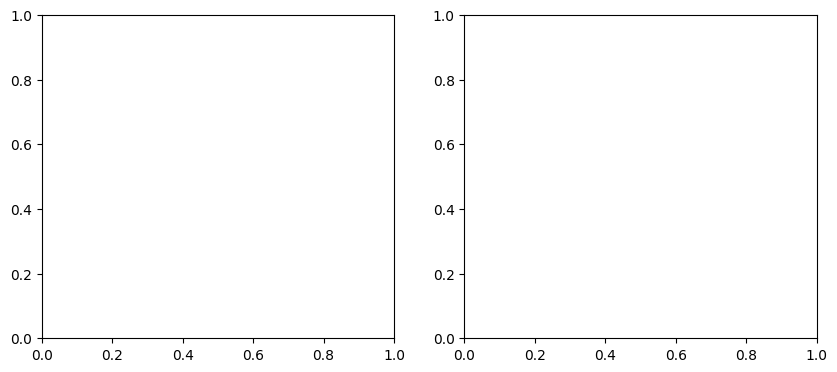

In [5]:
# %% [markdown]
# ### Barridos por métrica y guardado de resultados

# %%
# ULSE
df_ulse = eval_ulse_over_k(X_high_full, X_low_full, labels_full, GRID_ULSE_K, B_ULSE, SEED)
df_ulse.to_csv(os.path.join(RESDIR, "6_3_ajuste_ULSE.csv"), index=False)
dual_panel_metric_time(
    x=df_ulse["param"].values,
    m_mean=df_ulse["mean"].values, m_std=df_ulse["std"].values,
    t_mean=df_ulse["t_mean"].values, t_std=df_ulse["t_std"].values,
    title="6.3 · ULSE vs k (media ± desvío) y tiempo",
    xlabel="k (vecinos)", ylabel_m="ULSE", ylabel_t="segundos/evaluación",
    file_out=os.path.join(FIGDIR, "6_3_ajuste_ULSE.png")
)

# RTA
df_rta = eval_rta_over_T(X_high_full, X_low_full, labels_full, GRID_RTA_T, B_RTA, SEED)
df_rta.to_csv(os.path.join(RESDIR, "6_3_ajuste_RTA.csv"), index=False)
dual_panel_metric_time(
    x=df_rta["param"].values,
    m_mean=df_rta["mean"].values, m_std=df_rta["std"].values,
    t_mean=df_rta["t_mean"].values, t_std=df_rta["t_std"].values,
    title="6.3 · RTA vs nº tríos T (media ± desvío) y tiempo",
    xlabel="T (nº de tríos)", ylabel_m="RTA", ylabel_t="segundos/evaluación",
    file_out=os.path.join(FIGDIR, "6_3_ajuste_RTA.png")
)

# Spearman
df_spear = eval_spearman_over_P(X_high_full, X_low_full, labels_full, GRID_SPEAR_P, B_SPEAR, SEED)
df_spear.to_csv(os.path.join(RESDIR, "6_3_ajuste_Spearman.csv"), index=False)
dual_panel_metric_time(
    x=df_spear["param"].values,
    m_mean=df_spear["mean"].values, m_std=df_spear["std"].values,
    t_mean=df_spear["t_mean"].values, t_std=df_spear["t_std"].values,
    title="6.3 · Spearman vs nº pares P (media ± desvío) y tiempo",
    xlabel="P (nº de pares)", ylabel_m="Spearman", ylabel_t="segundos/evaluación",
    file_out=os.path.join(FIGDIR, "6_3_ajuste_Spearman.png")
)

# k-NCP (por clases)
df_kncp = eval_kncp_over_k(X_high_full, X_low_full, labels_full, GRID_KNCP_K, B_KNCP, SEED)
df_kncp.to_csv(os.path.join(RESDIR, "6_3_ajuste_kNCP.csv"), index=False)
dual_panel_metric_time(
    x=df_kncp["param"].values,
    m_mean=df_kncp["mean"].values, m_std=df_kncp["std"].values,
    t_mean=df_kncp["t_mean"].values, t_std=df_kncp["t_std"].values,
    title="6.3 · k-NCP vs k (clases) (media ± desvío) y tiempo",
    xlabel="k (vecinos de clase)", ylabel_m="k-NCP", ylabel_t="segundos/evaluación",
    file_out=os.path.join(FIGDIR, "6_3_ajuste_kNCP.png")
)

# CDC (sin parámetro): solo estabilidad y tiempo medio
df_cdc = eval_cdc_stability(X_high_full, X_low_full, labels_full, B_CDC, SEED)
df_cdc.to_csv(os.path.join(RESDIR, "6_3_ajuste_CDC.csv"), index=False)
line_with_band(
    x=[0], y_mean=df_cdc["mean"].values, y_std=df_cdc["std"].values,
    title="6.3 · CDC (estabilidad)", xlabel="CDC", ylabel="valor",
    file_out=os.path.join(FIGDIR, "6_3_ajuste_CDC.png"), ylim=(0,1)
)

# Resumen con recomendación automática según CI95 ≤ EPS (cuando aplique)
def pick_recommended(df, eps=EPS):
    df2 = df.copy()
    if "param" not in df2.columns:  # CDC
        return {"param":"-", "mean":df2.at[0,"mean"], "ci95":df2.at[0,"ci95"], "t_mean":df2.at[0,"t_mean"]}
    ok = df2[df2["ci95"] <= eps]
    if len(ok) > 0:
        # elegimos el menor parámetro que ya cumple estabilidad
        rec = ok.iloc[0]
    else:
        # si ninguno cumple, nos quedamos con el mejor compromiso media/tiempo (heurística simple)
        df2 = df2.assign(score=df2["mean"] / (df2["t_mean"] + 1e-9))
        rec = df2.sort_values("score", ascending=False).iloc[0]
    return {"param": rec["param"], "mean": rec["mean"], "ci95": rec["ci95"], "t_mean": rec["t_mean"]}

summary = pd.DataFrame({
    "ULSE":    [pick_recommended(df_ulse)],
    "RTA":     [pick_recommended(df_rta)],
    "Spearman":[pick_recommended(df_spear)],
    "k-NCP":   [pick_recommended(df_kncp)],
    "CDC":     [pick_recommended(df_cdc)],
}).T
summary.columns = ["recomendación"]
summary_out = pd.concat([pd.Series({"param": v["param"], "mean": v["mean"], "ci95": v["ci95"], "t_mean": v["t_mean"]}, name=k)
                         for k,v in summary["recomendación"].to_dict().items()], axis=1).T
display(summary_out)
summary_out.to_csv(os.path.join(RESDIR, "6_3_ajuste_resumen.csv"))
